#**Step 1: Install All the Required Packages**

In [ ]:
!pip3 install -q -U bitsandbytes==0.42.0
!pip3 install -q -U peft==0.8.2
!pip3 install -q -U trl==0.7.10
!pip3 install -q -U accelerate==0.27.1
!pip3 install -q -U datasets==2.17.0
!pip3 install -q -U transformers==4.38.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.4/183.4 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.9/150.9 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.0/102.0 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.7/279.7 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 11.5 MB/s eta 0:00:00
     ━━

#**Step 2: Import All the Required Libraries**

In [ ]:
import os
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from google.colab import userdata
from datasets import load_dataset
from transformers import (

    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
    Trainer,
    GemmaTokenizer
)
from peft import LoraConfig, PeftModel
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix)

In [ ]:
from google.colab import userdata
os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')

#**Step 3**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import transformers
from trl import SFTTrainer

In [ ]:
# The model that you want to train from the Hugging Face hub
model_name = "google/codegemma-7b-it"


bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(model_name, token=os.environ['HF_TOKEN'])
model = AutoModelForCausalLM.from_pretrained(
    model_name, quantization_config=bnb_config, device_map={"":0}, token=os.environ['HF_TOKEN'])

# Fine-tuned model name
new_model = "codegemma-7b-it-finetune"


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
os.environ["WANDB_DISABLED"] = "true"

lora_config = LoraConfig(
    r=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM",
)
dataset = load_dataset("SadiaAfreen1048/codeVulnerabilityCodeGemma")
dataset = dataset.map(lambda samples: tokenizer(samples["func"]), batched=True)

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/2100 [00:00<?, ? examples/s]

In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['func', 'input_ids', 'attention_mask'],
        num_rows: 2100
    })
})


In [ ]:
print(dataset['train'][0]['func'])

<bos><start_of_turn>user
            Analyze the code of the program enclosed in square brackets. If the code has vulnerability,
            then answer with 1, else answer with 0.
            [inline void Logistic(const uint8* input_data, const Dims<4>& input_dims,
                     int32 input_zero_point, int32 input_range_radius,
                     int32 input_multiplier, int input_left_shift,
                     uint8* output_data, const Dims<4>& output_dims) {
  Logistic(input_data, DimsToShape(input_dims), input_zero_point,
           input_range_radius, input_multiplier, input_left_shift, output_data,
           DimsToShape(output_dims));
}]<end_of_turn>
            0


In [ ]:
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset["train"],
    dataset_text_field='func',
    args=transformers.TrainingArguments(
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,
        warmup_steps=2,
        max_steps=10,
        learning_rate=2e-4,
        fp16=True,
        logging_steps=1,
        output_dir="outputs",
        optim="paged_adamw_8bit"
    ),
    peft_config=lora_config,
)
trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:223: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/2100 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:290: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(


Step,Training Loss
1,3.611600
2,5.402500
3,3.160200
4,2.268700
5,3.907800
6,6.876500
7,3.496400
8,2.395700
9,3.000300
10,2.981000


TrainOutput(global_step=10, training_loss=3.7100676536560058, metrics={'train_runtime': 19.4291, 'train_samples_per_second': 2.059, 'train_steps_per_second': 0.515, 'total_flos': 1054739564359680.0, 'train_loss': 3.7100676536560058, 'epoch': 0.02})

In [ ]:
print(model)

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 3072, padding_idx=0)
    (layers): ModuleList(
      (0-27): 28 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): lora.Linear4bit(
            (base_layer): Linear4bit(in_features=3072, out_features=4096, bias=False)
            (lora_dropout): ModuleDict(
              (default): Identity()
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=3072, out_features=8, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=8, out_features=4096, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
          )
          (k_proj): lora.Linear4bit(
            (base_layer): Linear4bit(in_features=3072, out_features=4096, bias=False)
            (lora_dropout): ModuleDict(
              (default): Identity()
            )
         

In [ ]:
# Save trained model
trainer.model.save_pretrained('/content/drive/MyDrive/gemma/'+new_model)

##**Step 5: Check the plots on tensorboard, as follows**

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir results/runs

In [ ]:
import gc
for _ in range(100):
    torch.cuda.empty_cache()
    gc.collect()
gc.collect()

0

In [ ]:
X_test = pd.read_csv('/content/drive/MyDrive/gemma/data/test_data.csv')
y_true = pd.read_csv('/content/drive/MyDrive/gemma/data/y_true.csv')

In [ ]:
print(X_test.iloc[0]["func"])

<bos><start_of_turn>user
            Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [TEST_F(QueryPlannerTest, SparseIndexCanSupportGTEOrLTENull) {
    params.options &= ~QueryPlannerParams::INCLUDE_COLLSCAN;
    addIndex(BSON("i" << 1),
             false,  // multikey
             true    // sparse
    );

    runQuery(fromjson("{i: {$gte: null}}"));
    assertNumSolutions(1U);
    assertSolutionExists(
        "{fetch: {filter: {i: {$gte: null}}, node: {ixscan: {pattern: "
        "{i: 1}, bounds: {i: [[null,null,true,true]]}}}}}");

    runQuery(fromjson("{i: {$lte: null}}"));
    assertNumSolutions(1U);
    assertSolutionExists(
        "{fetch: {filter: {i: {$lte: null}}, node: {ixscan: {pattern: "
        "{i: 1}, bounds: {i: [[null,null,true,true]]}}}}}");
}]<end_of_turn>


In [ ]:
# Maximum length allowed for sequences
max_length = 1024

# Function to clip sequences
def clip_sequence(sequence):
    tokens = tokenizer.tokenize(sequence)
    if len(tokens) > max_length:
        return None
    clipped_tokens = tokens[:max_length]  # Account for [CLS] and [SEP] tokens
    return tokenizer.convert_tokens_to_string(clipped_tokens)

# Clip sequences in the DataFrame
X_test['func'] = X_test['func'].apply(clip_sequence)

# Filter out None values
X_test = X_test.dropna()

# Randomly select 300 data points
random_indices = X_test.sample(n=300, random_state=42).index
X_test = X_test.loc[random_indices]
y_true = y_true.loc[random_indices]

# y_true = y_true.loc[X_test.index]  # Align y_true with the filtered X_test indices

# Print the updated DataFrame
print(X_test)
print(y_true)

                                                  func
366  <bos><start_of_turn>user\n            Analyze ...
102  <bos><start_of_turn>user\n            Analyze ...
96   <bos><start_of_turn>user\n            Analyze ...
254  <bos><start_of_turn>user\n            Analyze ...
399  <bos><start_of_turn>user\n            Analyze ...
..                                                 ...
477  <bos><start_of_turn>user\n            Analyze ...
813  <bos><start_of_turn>user\n            Analyze ...
650  <bos><start_of_turn>user\n            Analyze ...
330  <bos><start_of_turn>user\n            Analyze ...
601  <bos><start_of_turn>user\n            Analyze ...

[300 rows x 1 columns]
     label
366      0
102      0
96       0
254      0
399      1
..     ...
477      1
813      1
650      0
330      1
601      1

[300 rows x 1 columns]


In [ ]:
print(X_test.shape)

(300, 1)


In [ ]:
print(X_test.iloc[1].values[0])


<bos><start_of_turn>user
            Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static void kvm_pit_ack_irq(struct kvm_irq_ack_notifier *kian)
{
	struct kvm_kpit_state *ps = container_of(kian, struct kvm_kpit_state,
						 irq_ack_notifier);
	int value;

	spin_lock(&ps->inject_lock);
	value = atomic_dec_return(&ps->pending);
	if (value < 0)
		/* spurious acks can be generated if, for example, the
		 * PIC is being reset.  Handle it gracefully here
		 */
		atomic_inc(&ps->pending);
	else if (value > 0)
		/* in this case, we had multiple outstanding pit interrupts
		 * that we needed to inject.  Reinject
		 */
		queue_kthread_work(&ps->pit->worker, &ps->pit->expired);
	ps->irq_ack = 1;
	spin_unlock(&ps->inject_lock);
}]<end_of_turn>


In [ ]:
# prompt: print the first value of y_true without name or other shape info

print(y_true.iloc[1].values[0])


0


In [ ]:
text = "<start_of_turn>user\nAnalyze the code of the program enclosed in square brackets,\nif it has vulnerability then answer with 1, else answer with 0.\n [parse_STACK_POP(char *arg, const struct ofpact_parse_params *pp)\n {\n return nxm_parse_stack_action(ofpact_put_STACK_POP(pp->ofpacts), arg);\n}]<end_of_turn>"
device = "cuda:0"
inputs = tokenizer(text, return_tensors="pt").to(device)
with torch.cuda.amp.autocast():
  outputs = model.generate(**inputs, max_new_tokens=20)

print(tokenizer.decode(outputs[0], skip_special_tokens=False))

<bos><start_of_turn>user
Analyze the code of the program enclosed in square brackets,
if it has vulnerability then answer with 1, else answer with 0.
 [parse_STACK_POP(char *arg, const struct ofpact_parse_params *pp)
 {
 return nxm_parse_stack_action(ofpact_put_STACK_POP(pp->ofpacts), arg);
}]<end_of_turn>
0 or 1<eos>


In [ ]:
def predict(test, model, tokenize):
    y_pred = []
    device = "cuda:0"
    for i in tqdm(range(len(X_test))):
        prompt = X_test.iloc[i]["func"]
        inputs = tokenizer(prompt, return_tensors="pt").to(device)
        with torch.cuda.amp.autocast():
          outputs = model.generate(**inputs, max_new_tokens=50)
        result = tokenizer.decode(outputs[0], skip_special_tokens=True)
        print('result: '+result)
        answer = result.split("<end_of_turn>")[-1]
        print("True Answer: ")
        print(y_true.iloc[i].values[0])
        if "is vulnerable" in answer or "1" in answer:
            print("Answer: 1")
            y_pred.append("1")
        elif "is not vulnerable" in answer or "0" in answer:
            print("Answer: 0")
            y_pred.append("0")
        else:
            print("Answer: 0")
            y_pred.append("0")
    return y_pred

In [ ]:
y_pred = predict(X_test, model, tokenizer)

In [ ]:
print(y_pred)
print(y_true)

['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '1', '0', '0', '0', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '0', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '0', '1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1',

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,  f1_score, precision_score, recall_score

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in ((i, j) for i in range(cm.shape[0]) for j in range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def evaluate(y_true, y_pred):
    labels = [0, 1]
    mapping = {'0': 0, '1': 1}
    def map_func(x):
        return mapping.get(x, 0)

    mapping2 = {0: 0, 1: 1}
    def map_func2(x):
        return mapping2.get(x, 0)

    y_true = np.vectorize(map_func2)(y_true)
    y_pred = np.vectorize(map_func)(y_pred)

    # Calculate accuracy
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    print(f'Accuracy: {accuracy:.3f}')

    # Calculate precision
    precision = precision_score(y_true=y_true, y_pred=y_pred)
    print(f'Precision: {precision:.3f}')

    # Calculate recall
    recall = recall_score(y_true=y_true, y_pred=y_pred)
    print(f'Recall: {recall:.3f}')

    # Calculate f1
    f1 = f1_score(y_true=y_true, y_pred=y_pred)
    print(f'F1 Score: {f1:.3f}')

    # Generate accuracy report
    unique_labels = np.unique(y_true)  # Get unique labels

    for label in unique_labels:
        label_indices = [i for i in range(len(y_true))
                         if y_true[i] == label]
        label_y_true = [y_true[i] for i in label_indices]
        label_y_pred = [y_pred[i] for i in label_indices]
        accuracy = accuracy_score(label_y_true, label_y_pred)
        print(f'Accuracy for label {label}: {accuracy:.3f}')

    # Generate classification report
    class_report = classification_report(y_true=y_true, y_pred=y_pred)
    print('\nClassification Report:')
    print(class_report)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=[0, 1])
    print('\nConfusion Matrix:')
    print(conf_matrix)

    # Plot confusion matrix
    plot_confusion_matrix(conf_matrix, classes=labels, title='Confusion Matrix')

Accuracy: 0.440
Precision: 0.434
Recall: 0.872
F1 Score: 0.580
Accuracy for label 0: 0.096
Accuracy for label 1: 0.872

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.10      0.16       167
           1       0.43      0.87      0.58       133

    accuracy                           0.44       300
   macro avg       0.46      0.48      0.37       300
weighted avg       0.46      0.44      0.35       300


Confusion Matrix:
[[ 16 151]
 [ 17 116]]
Confusion matrix, without normalization


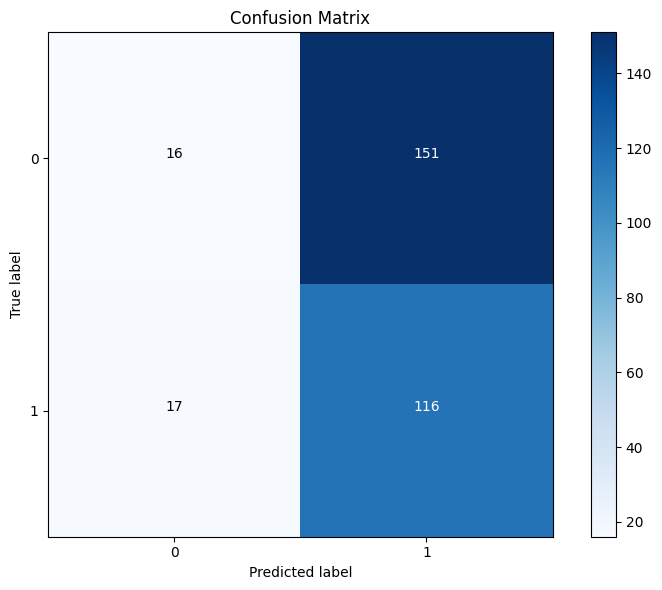

In [ ]:
evaluate(y_true, y_pred)